# FVC Idle Images

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import json
from pathlib import Path

In [4]:
import pandas as pd

In [3]:
import desietc.plot
import desietc.db

In [4]:
import fpoffline.db
import fpoffline.fvc
import fpoffline.hwtable

In [5]:
with open('idle-96032.json') as f:
    T = json.load(f)

In [6]:
with open('constants-194.json') as f:
    F = json.load(f)
    K = {E["name"]:E["constants"] for E in F["elements"]}

In [7]:
def load_hwtables():
    HWTABLES = Path('hwtables')
    assert HWTABLES.exists()
    dfs = [pd.read_csv(csv) for csv in HWTABLES.glob('hwtables_ptlid??_96032__*.csv')]
    return pd.concat(dfs, ignore_index=True)

HW = load_hwtables()

Load the idle image and apply stretch to better show faint arcs:

In [5]:
img = np.load('idle-96032.npy')

In [11]:
stretched = np.arcsinh(img/200)

In [12]:
fpoffline.fvc.plot_fvc(stretched, save='idle-96032.jpg');

Fetch the moves associated with this exposure:

In [13]:
DB = desietc.db.DB()

In [14]:
%time M = fpoffline.db.get_moves(DB, expid=96032)

Found 1001 rows of move data for petal loc[0] id[4]


ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 3


Fetch the calibration valid during this exposure:

In [17]:
%time C = fpoffline.db.get_calib(DB, at=M['time_recorded'].min())

Found calibration data for 502 positioners on petal loc[0] id[4]
Found calibration data for 502 positioners on petal loc[1] id[5]
Found calibration data for 502 positioners on petal loc[2] id[6]
Found calibration data for 502 positioners on petal loc[3] id[3]
Found calibration data for 502 positioners on petal loc[4] id[8]
Found calibration data for 502 positioners on petal loc[5] id[10]
Found calibration data for 502 positioners on petal loc[6] id[11]
Found calibration data for 502 positioners on petal loc[7] id[2]
Found calibration data for 502 positioners on petal loc[8] id[7]
Found calibration data for 502 positioners on petal loc[9] id[9]
CPU times: user 626 ms, sys: 153 ms, total: 779 ms
Wall time: 12.9 s


In [15]:
class Scheduler:
    """Initialize a new move scheduler for a positioner.
    """
    CLOCK = 18000                 # tick frequency in Hz
    PAUSE = 18                    # clock ticks per unit of pause
    CREEP_STEP = 0.1              # motor rotation in degrees for a single creep step
    CRUISE_RATIO = 33             # ratio of cruise and creep motor rotations for a single step
    GEAR_RATIO = (46.0/14.0+1)**4 # Namiki "337:1" gear box (GEAR_TYPE_P,T in constants db)

    PETAL_IDS = [4, 5, 6, 3, 8, 10, 11, 2, 7, 9]

    default_const = dict(
        CREEP_PERIOD=2, SPINUPDOWN_PERIOD=12, MOTOR_CCW_DIR_T=-1, MOTOR_CCW_DIR_P=-1,
        GEAR_TYPE_T='namiki', GEAR_TYPE_P='namiki')

    default_calib = dict(
        length_r1=3.0, length_r2=3.0, offset_t=0.0, offset_p=0.0,
        offset_x=0.0, offset_y=0.0, gear_calib_t=1.0, gear_calib_p=1.0)

    class Motor:
        """
        """
        def __init__(self, CREEP_PERIOD=2, SPINUPDOWN_PERIOD=12, ccw=-1, ratio=1):
            self.CREEP_PERIOD = CREEP_PERIOD
            self.SPINUPDOWN_PERIOD = SPINUPDOWN_PERIOD
            self.dw = ccw * ratio * Scheduler.CREEP_STEP * Scheduler.CLOCK / (self.CREEP_PERIOD * Scheduler.GEAR_RATIO)
            self.increment = []
            self.duration = []
            self.nticks = 0

        def creep(self, steps):
            if steps==0: return
            direction, nsteps = (1,steps) if steps > 0 else (-1,-steps)
            self.increment.append(direction)
            self.duration.append(self.CREEP_PERIOD * nsteps)
            self.nticks += self.duration[-1]

        def cruise(self, steps):
            if steps==0: return
            direction, nsteps = (1,steps) if steps > 0 else (-1,-steps)
            nupdown = Scheduler.CRUISE_RATIO
            spin_up_down = [(i + 1) * direction * self.CREEP_PERIOD for i in range(nupdown)]
            self.increment.extend(spin_up_down + spin_up_down[-1:] + spin_up_down[::-1])
            self.duration.extend([self.SPINUPDOWN_PERIOD] * nupdown + [nsteps] + [self.SPINUPDOWN_PERIOD] * nupdown)
            self.nticks += 2 * self.SPINUPDOWN_PERIOD * Scheduler.CRUISE_RATIO + nsteps

        def pause(self, steps, unit=None):
            unit = unit or Scheduler.PAUSE
            if steps < 0: raise ValueError('Invalid steps < 0.')
            if steps == 0: return
            self.increment.append(0)
            self.duration.append(steps * unit)
            self.nticks += self.duration[-1]

        def move(self, steps, mode, pause):
            if mode == 'creep': self.creep(steps)
            elif mode == 'cruise': self.cruise(steps)
            else: raise ValueError(f'Invalid move mode "{mode}".')
            self.pause(pause)
            assert len(self.increment) == len(self.duration)

        def finalize(self):
            omega = np.array(self.increment) * self.dw
            dt = np.array(self.duration) / Scheduler.CLOCK
            n = len(self.increment) + 1
            self.time = np.empty(n, np.float32)
            self.angle = np.empty(n, np.float32)
            self.time[0] = self.angle[0] = 0
            self.time[1:] = np.cumsum(dt)
            self.angle[1:] = np.cumsum(omega * dt)

    def __init__(self, const=default_const, calib=default_calib):
        if const['GEAR_TYPE_T'] != 'namiki' or const['GEAR_TYPE_P'] != 'namiki':
            raise ValueError('Only "namiki" gears are supported.')
        self.const = const
        self.calib = calib

    def plan(self, move, motor_steps_T, speed_mode_T, motor_steps_P, speed_mode_P, postpause):
        """
        """
        args = (motor_steps_T, speed_mode_T, motor_steps_P, speed_mode_P, postpause)
        try:
            lens = [len(arg) for arg in (motor_steps_T, speed_mode_T, motor_steps_P, speed_mode_P, postpause)]
            assert min(lens) == max(lens)
        except (TypeError, AssertionError):
            raise RuntimeError('Arguments must be arrays of the same length.')

        # Schedule the move table.
        self.motor_T = Scheduler.Motor(
            self.const['CREEP_PERIOD'], self.const['SPINUPDOWN_PERIOD'],
            self.const['MOTOR_CCW_DIR_T'], self.calib['gear_calib_t'])
        self.motor_P = Scheduler.Motor(
            self.const['CREEP_PERIOD'], self.const['SPINUPDOWN_PERIOD'],
            self.const['MOTOR_CCW_DIR_P'], self.calib['gear_calib_p'])
        for (steps_T, mode_T, steps_P, mode_P, pause) in zip(*args):
            self.motor_T.move(steps_T, mode_T, pause)
            self.motor_P.move(steps_P, mode_P, pause)
            # Add extra delay to one motor, if needed, to keep both in synch.
            delta = self.motor_T.nticks - self.motor_P.nticks
            if delta > 0:
                self.motor_P.pause(+delta, 1)
            elif delta < 0:
                self.motor_T.pause(-delta, 1)
        self.motor_T.finalize()
        self.motor_P.finalize()

        # Calculate theta,phi angles [in deg] with theta relative to CS5 +x and phi relative to theta,
        # such that the move ends up at T=move['pos_t'], P=move['pos_p'].
        petal_loc = self.PETAL_IDS.index(move['petal_id'])
        petal_T = (petal_loc - 3) * 36
        T0 = petal_T + self.calib['offset_t'] + move['pos_t'] - self.motor_T.angle[-1]
        P0 = self.calib['offset_p'] + move['pos_p'] - self.motor_P.angle[-1]
        self.time = np.unique(np.concatenate((self.motor_T.time, self.motor_P.time)))
        self.theta = np.interp(self.time, self.motor_T.time, self.motor_T.angle + T0)
        self.phi = np.interp(self.time, self.motor_P.time, self.motor_P.angle + P0)

        # Calculate CS5 coords [in mm] of the theta, phi arm endpoints.
        tstep = self.const['CREEP_PERIOD'] / self.CLOCK
        nt = int(np.ceil(self.time[-1] / tstep)) + 1
        self.t = np.linspace(0, self.time[-1], nt)
        T = np.interp(self.t, self.time, np.deg2rad(self.theta))
        TP = np.interp(self.t, self.time, np.deg2rad(self.theta + self.phi))
        C, S = np.cos(np.deg2rad(petal_T)), np.sin(np.deg2rad(petal_T))
        x0, y0 = self.calib['offset_x'], self.calib['offset_y']
        self.x0, self.y0 = x0 * C - y0 * S, x0 * S + y0 * C
        self.rT, self.rP = self.calib['length_r1'], self.calib['length_r2']
        self.xT = self.x0 + self.rT * np.cos(T)
        self.yT = self.y0 + self.rT * np.sin(T)
        self.xP = self.xT + self.rP * np.cos(TP)
        self.yP = self.yT + self.rP * np.sin(TP)

In [16]:
def getpath(trans, const, calib, move, hwtable):
    """
    """
    # Calulate the path of the fiber in focal-plane coords.
    sched = Scheduler(const, calib)
    hw = lambda k: json.loads(hwtable[k].replace("'", '"'))
    sched.plan(move, hw('motor_steps_T'), hw('speed_mode_T'), hw('motor_steps_P'), hw('speed_mode_P'), hw('postpause'))
    fp = np.stack((sched.xP, sched.yP))

    # Convert to FVC pixels.
    FP = np.array(trans['FP'])
    FVC = np.array(trans['FVC'])
    dFVC = np.stack([trans['dFVCdx'], trans['dFVCdy']])
    ## minus sign on x for the usual FVC view of the focal plane.
    ##xflip = np.array([-1, +1]).reshape(2, 1)
    return FVC.reshape(2, 1) + dFVC.dot(fp - FP.reshape(2, 1))

In [26]:
def plot(posID, size=1000, zoom=1, offset=[-21,+25], save=None):

    offset = np.array(offset)
    xyfvc = np.array(T[posID]['FVC'])
    ix, iy = np.round(xyfvc - size/2).astype(int)
    origin = np.array([ix, iy])

    stamp = stretched[iy:iy+size, ix:ix+size][:,::-1]
    fig,ax = desietc.plot.plot_pixels(stamp, zoom=zoom)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Loop over visible positioners
    near = {posID:row for posID,row in T.items() if
            (np.abs(row['FVC'][0] - xyfvc[0] - offset[0]) < size/2) & (np.abs(row['FVC'][1] - xyfvc[1] + offset[1]) < size/2)}
    for pid in near:

        tt = T[pid]
        x, y = size - (tt['FVC'][0] - ix) + offset[0], tt['FVC'][1] - iy + offset[1]
        #ax.plot(x, y, 'c+', ms=10)
        ax.text(x, y, pid, ha='center', va='center', color='c', fontsize=8)

        try:
            # Look up the calibration, move, and hwtable for this device.
            c = C.query(f'(pos_id=="{pid}")').iloc[0].to_dict()
            m = M.query(f'(pos_id=="{pid}")').iloc[0].to_dict()
            h = HW.query(f'(posid=="{pid}")').iloc[0].to_dict()
            # Calculate the fiber path in FP coords.
            sched = fpoffline.hwtable.Scheduler(K[pid], c)
            sched.plan(h)
            sched.get_path_for_move(m)
            fp = np.stack((sched.x_fp, sched.y_fp))
            # Convert to FVC pixels.
            FP = np.array(tt['FP'])
            FVC = np.array(tt['FVC'])
            dFVC = np.stack([tt['dFVCdx'], tt['dFVCdy']])
            xfvc, yfvc = FVC.reshape(2, 1) + dFVC.dot(fp - FP.reshape(2, 1))
            # Overlay the path.
            plt.plot(size - (xfvc - ix) + offset[0], yfvc - iy + offset[1], 'c-', lw=1, alpha=1)
        except IndexError:
            pass

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if save:
        plt.savefig(save)

plot('M05303', save='idle.png')

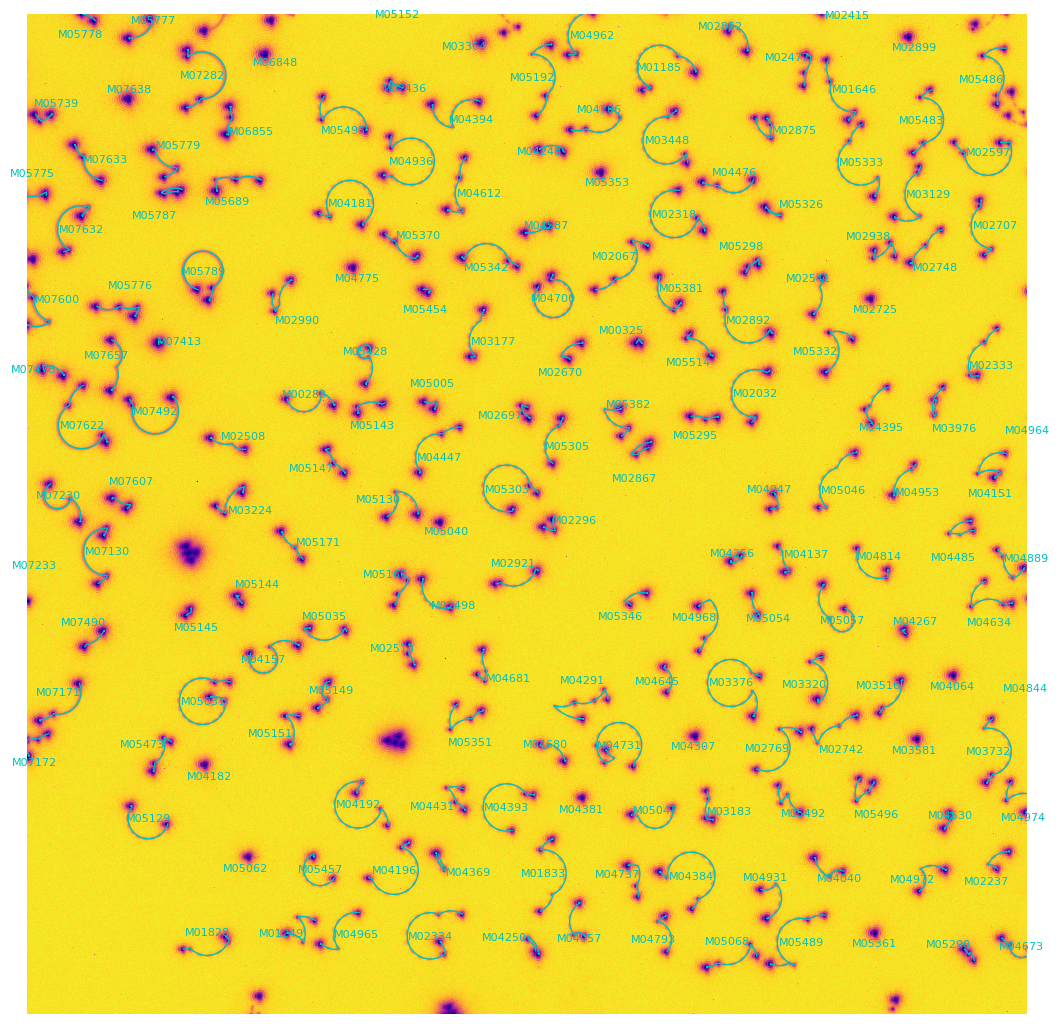

In [ ]:
def plot2(posID, size=1000, zoom=1, offset=[-21,+25], save=None):

    offset = np.array(offset)
    xyfvc = np.array(T[posID]['FVC'])
    ix, iy = np.round(xyfvc - size/2).astype(int)
    origin = np.array([ix, iy])

    stamp = stretched[iy:iy+size, ix:ix+size][:,::-1]
    fig,ax = desietc.plot.plot_pixels(stamp, zoom=zoom)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Loop over visible positioners
    near = {posID:row for posID,row in T.items() if
            (np.abs(row['FVC'][0] - xyfvc[0] - offset[0]) < size/2) & (np.abs(row['FVC'][1] - xyfvc[1] + offset[1]) < size/2)}
    for pid in near:

        tt = T[pid]
        x, y = size - (tt['FVC'][0] - ix) + offset[0], tt['FVC'][1] - iy + offset[1]
        #ax.plot(x, y, 'c+', ms=10)
        ax.text(x, y, pid, ha='center', va='center', color='c', fontsize=8)

        try:
            c = C.query(f'(pos_id=="{pid}")').iloc[0].to_dict()
            m = M.query(f'(pos_id=="{pid}")').iloc[0].to_dict()
            h = HW.query(f'(posid=="{pid}")').iloc[0].to_dict()
            xfvc, yfvc = getpath(tt, K[pid], c, m, h)
            plt.plot(size - (xfvc - ix) + offset[0], yfvc - iy + offset[1], 'c-', lw=1, alpha=1)
        except IndexError:
            pass

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if save:
        plt.savefig(save)

plot('M05303', save='idle2.png')